In [8]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import cmcrameri as cmc
import glob
from velocity_leakage import S1DopplerLeakage
from matplotlib.ticker import FormatStrFormatter

In [9]:
def decorrelation(tau, T):
        return np.exp(-(tau/T)**2)

def pulse_pair_sigma_v(T_pp, T_corr_surface, T_corr_Doppler, SNR, Lambda, N_L = 1):
        """
        Calculates the Pulse pair velocity standard deviation within a resolution cell due to coherence loss

        NOTE assumes broadside geometry (non-squinted)

        Parameters
        ----------
        T_pp : scaler
            Intra pulse pair time separation
        T_corr_surface : scaler
            Decorrelation time of ocean surface at scales of radio wavelength of interest
        T_corr_Doppler : scaler
            Decorrelation time of velocities within resolution cell as a result of satellite motion during pulse-pair transmit
        SNR : scaler
            Signal to Noise ratio (for pulse-pair system we assume signal to clutter ratio of 1 dominates)
        Lambda : scaler
            Wavelength of considered radiowave
        N_L : int
            Number of independent looks for given area

        Returns
        -------
        Scaler of estimates surface velocity standard deviation

        """
        wavenumber = 2 * np.pi / Lambda 

        gamma_velocity = decorrelation(T_pp, T_corr_Doppler) # eq 6 & 7 Rodriguez (2018), NOTE not valid for squint NOTE assumes Gaussian beam pattern
        gamma_temporal = decorrelation(T_pp, T_corr_surface)
        gamma_SNR = SNR / (1 + SNR)

        gamma = gamma_temporal * gamma_SNR * gamma_velocity
        
        variance = (1 / (2*wavenumber*T_pp))**2 / (2*N_L) * (1-gamma**2)/gamma**2 # eq 14 Rodriguez (2018)

        return np.sqrt(variance), gamma


def uncertainty_leakage(backscatter_gradient = 0.1, sigma_az_beampattern = 0.004, v_sat = 6_800, azimuth_angle = np.pi/2):
    """
    LoS velocity uncertainty due to leakage
    
    """
    gradient_non_db = 10**(backscatter_gradient /10) - 1
    V_leakage = gradient_non_db * sigma_az_beampattern * v_sat * np.sin(azimuth_angle) #* np.cos(look_angle)
    return V_leakage


def uncertainty_pulse_pair(wavelength = 0.055, T_pp = 1.15E-4, U = 6,  N_L = 2.5E3, sigma_az_beampattern = 0.004, SNR = 1, v_sat = 6800):
    """"
    U = 6 # Average wind speed assumed of 6 m/s
    
    """

    wavenumber = 2 * np.pi / wavelength 
    T_corr_Doppler = 1/ (np.sqrt(2) * wavenumber * v_sat * sigma_az_beampattern)
    T_corr_surface = 3.29 * wavelength / U

    velocity_error, gamma = pulse_pair_sigma_v(
    T_pp = T_pp, 
    T_corr_surface = T_corr_surface, 
    T_corr_Doppler = T_corr_Doppler, 
    SNR = SNR,  
    Lambda = wavelength,
    N_L=N_L)

    return velocity_error, gamma

In [10]:
backscatter_gradient = 0.1 # 0.1 dB for Dopplerscatt# np.linspace(0,1, 11)
wavelength = 0.055
T_pp = 1.15E-4
U = 6
N_L = 2.5E3
sigma_az_beampattern = 0.0036 # sigma_az_angle # 0.02 for Dopplerscat
SNR = 1
v_sat = 6800 # 130 for Dopplerscatt


sigma_L = uncertainty_leakage(
    backscatter_gradient=backscatter_gradient, 
    sigma_az_beampattern=sigma_az_beampattern, 
    v_sat=v_sat)


sigma_PP = uncertainty_pulse_pair(
    wavelength = wavelength, 
    T_pp = T_pp, 
    U = U,  
    N_L = N_L, 
    sigma_az_beampattern = sigma_az_beampattern, #0.003, 
    SNR = SNR, 
    v_sat = v_sat)

# just to check the numbers are reasonable
sigma_L, sigma_PP

(0.5702124510328603, (1.2095209230475514, 0.4065596008059286))

In [11]:
N = 9
backscatter_gradient_ref = 0.1 
backscatter_gradient_perturb = np.linspace(0,1, N)

sigma_az_beampattern_ref = sigma_az_beampattern
sigma_az_beampattern_perturb = np.linspace(0, 2, N) * sigma_az_beampattern

sigma_L_backscatter = uncertainty_leakage(
    backscatter_gradient=backscatter_gradient_perturb, 
    sigma_az_beampattern=sigma_az_beampattern_ref, 
    v_sat=v_sat)

sigma_L_sigma_az = uncertainty_leakage(
    backscatter_gradient=backscatter_gradient_ref, 
    sigma_az_beampattern=sigma_az_beampattern_perturb, 
    v_sat=v_sat)


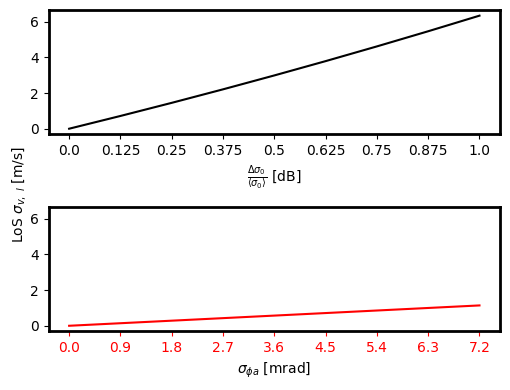

In [12]:
fig, ax = plt.subplots(2,1, figsize = (5, 4), sharey=True)
matplotlib.rcParams['axes.linewidth'] = 2

ax1 = ax[0]
ax2 = ax[1]

colormap = cmc.cm.vanimo.colors
c = 'k'#colormap[0]
c0 = 'red' #colormap[256//4]
linestyle = '-'
linewidth = 2

# Plotting on the primary axes
ax1.plot(backscatter_gradient_perturb, sigma_L_backscatter, color=c)
ax1.set_xticks(backscatter_gradient_perturb)
ax1.set_xticklabels( np.round(backscatter_gradient_perturb,4))
ax1.set_xlabel(r'$\frac{\Delta \sigma_0}{\left< \sigma_0\right>}$ [dB]')

# Adjusting the position of the secondary x-axis
ax2.set_xlabel(r'$\sigma_{\phi a}$ [mrad]')

# Attach ticks and labels to the secondary x-axis
ax2.xaxis.set_ticks_position('bottom')  # Set tick position
ax2.xaxis.set_label_position('bottom')  # Set label position

# Plotting on the secondary axes
ax2.plot(sigma_az_beampattern_perturb, sigma_L_sigma_az, color=c0)

ax2.xaxis.set_major_formatter(FormatStrFormatter('%.6s'))
# ax2.spines['bottom'].set_color(c0)
ax2.tick_params(axis='x', colors=c0)

ax2.set_xticks(sigma_az_beampattern_perturb)
ax2.set_xticklabels( np.round(1000*sigma_az_beampattern_perturb,4))

fig.tight_layout()
fig.text(-0.01, 0.5, r'LoS $\sigma_{v,\ l}$ [m/s]', va='center', rotation='vertical')

plt.show()


In [13]:
N = 9
T_pp_ref = T_pp
T_pp_perturbed = 1.5 * np.arange(0.25, 2.75, 0.25) * 0.0001

U_ref = U
U_perturbed = np.linspace(5, 25, 9)

sigma_az_beampattern_ref = sigma_az_beampattern
sigma_az_beampattern_perturb = np.linspace(0, 2, N) * sigma_az_beampattern

SNR_ref = SNR
SNR_perturbed =  np.linspace(0.25, 2.25, N)

sigma_PP_T_pp, _ = uncertainty_pulse_pair(
    wavelength = wavelength, 
    T_pp = T_pp_perturbed, 
    U = U_ref,  
    N_L = N_L, 
    sigma_az_beampattern = sigma_az_beampattern_ref, #0.003, 
    SNR = SNR_ref, 
    v_sat = v_sat)

sigma_PP_U, _ = uncertainty_pulse_pair(
    wavelength = wavelength, 
    T_pp = T_pp_ref, 
    U = U_perturbed,  
    N_L = N_L, 
    sigma_az_beampattern = sigma_az_beampattern_ref, #0.003, 
    SNR = SNR_ref, 
    v_sat = v_sat)

sigma_PP_sigma_az, _ = uncertainty_pulse_pair(
    wavelength = wavelength, 
    T_pp = T_pp_ref, 
    U = U_ref,  
    N_L = N_L, 
    sigma_az_beampattern = sigma_az_beampattern_perturb, #0.003, 
    SNR = SNR_ref, 
    v_sat = v_sat)

sigma_PP_SNR, _ = uncertainty_pulse_pair(
    wavelength = wavelength, 
    T_pp = T_pp_ref, 
    U = U_ref,  
    N_L = N_L, 
    sigma_az_beampattern = sigma_az_beampattern_ref, #0.003, 
    SNR = SNR_perturbed, 
    v_sat = v_sat)


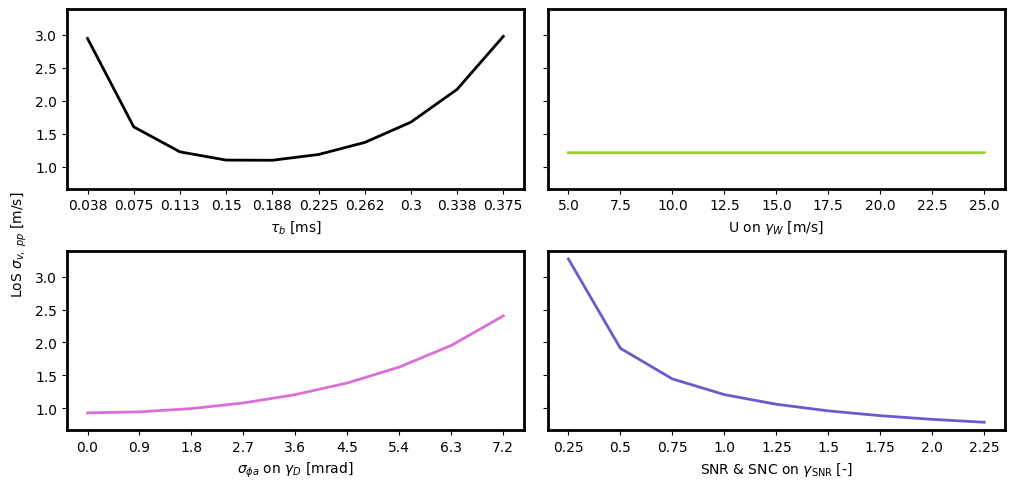

In [14]:

matplotlib.rcParams['axes.linewidth'] = 2

fig, ax = plt.subplots(2,2, figsize = (10, 5), sharey=True)

ax1 = ax[0,0]
ax2 = ax[0,1]
ax3 = ax[1,0]
ax4 = ax[1,1]


colormap = cmc.cm.vanimo.colors
c = 'k'#colormap[0]
c0 = 'yellowgreen' #colormap[256//4]
c1 = 'orchid' # colormap[256//2]
c2 = 'slateblue' # colormap[255]
linestyle = '-'
linewidth = 2

# Plotting on the primary axes
ax1.plot(T_pp_perturbed, sigma_PP_T_pp, linestyle=linestyle, linewidth=linewidth, color=c)
ax1.set_xticks(T_pp_perturbed)
ax1.set_xticklabels( np.round(1000*T_pp_perturbed,3))
ax1.set_xlabel(r'$\tau_b$ [ms]')

########################################################
# Attach ticks and labels to the secondary x-axis
ax2.xaxis.set_ticks_position('bottom')  # Set tick position
ax2.xaxis.set_label_position('bottom')  # Set label position

# Plotting on the secondary axes
ax2.plot(U_perturbed, sigma_PP_U, color=c0, linestyle=linestyle, linewidth=linewidth)
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.6s'))
ax2.set_xticks(U_perturbed)
ax2.set_xticklabels( np.round(U_perturbed,4))
ax2.set_xlabel(r'U on $\gamma_{W}$ [m/s]')

########################################################
ax3.set_xlabel(r'$\sigma_{\phi a}$ on $\gamma_D$ [mrad]')

# Attach ticks and labels to the secondary x-axis
ax3.xaxis.set_ticks_position('bottom')  # Set tick position
ax3.xaxis.set_label_position('bottom')  # Set label position

# Plotting on the secondary axes
ax3.plot(sigma_az_beampattern_perturb, sigma_PP_sigma_az, color=c1, linestyle=linestyle, linewidth=linewidth)
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.6s'))
ax3.set_xticks(sigma_az_beampattern_perturb)
ax3.set_xticklabels( 1000 *np.round(sigma_az_beampattern_perturb,4))


########################################################
ax4.set_xlabel(r'SNR & SNC on $\gamma_{\mathrm{SNR}}$ [-]')

# Attach ticks and labels to the secondary x-axis
ax4.xaxis.set_ticks_position('bottom')  # Set tick position
ax4.xaxis.set_label_position('bottom')  # Set label position

# Plotting on the secondary axes
ax4.plot(SNR_perturbed, sigma_PP_SNR, color=c2, linestyle=linestyle, linewidth=linewidth)
ax4.set_xticks(SNR_perturbed)
ax4.set_xticklabels( np.round(SNR_perturbed,2))



fig.tight_layout()
fig.text(-0.01, 0.5, r'LoS $\sigma_{v,\ pp}$ [m/s]', va='center', rotation='vertical')
plt.show()
